In [17]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [18]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 81.2 GB  | Proc size: 2.1 GB
GPU RAM Free: 10904MB | Used: 5264MB | Util  32% | Total 16376MB


In [19]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR100("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR100("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [21]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [22]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [23]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [24]:
strategy = FedCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,  # <-- pass the new strategy here
    client_resources=client_resources,

)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-16 10:20:56,955	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 27628498944.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'memory': 55256997888.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20264) [Client 3] evaluate, config: {}
(ClientAppActor pid=20264) Training time for Client 2: 23.35 seconds
(ClientAppActor pid=20264) Epoch 9: train loss 0.104606, accuracy 0.178444
(ClientAppActor pid=45548) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20264) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.304175853729248and 3habhhahah
this is tehb mode time [22.3]
This is ths last time not a fantasy 22.21237850189209and 7habhhahah
this is tehb mode time [22.3, 22.21]
This is ths last time not a fantasy 23.04201054573059and 4habhhahah
this is tehb mode time [22.3, 22.21, 23.04]
This is ths last time not a fantasy 22.281704664230347and 0habhhahah
this is tehb mode time [22.3, 22.21, 23.04, 22.28]
This is ths last time not a fantasy 22.342641353607178and 9habhhahah
this is tehb mode time [22.3, 22.21, 23.04, 22.28, 22.34]
This is ths last time not a fantasy 22.806761741638184and 1habhhahah
this is tehb mode time [22.3, 22.21, 23.04, 22.28, 22.34, 22.81]
This is ths last time not a fantasy 22.615679025650024and 8habhhahah
this is tehb mode time [22.3, 22.21, 23.04, 22.28, 22.34, 22.81, 22.62]
This is ths last time not a fantasy 22.395118474960327and 6habhhahah
this is tehb mode time [22.3, 22.21, 23.04, 22.28, 22.34, 22.81, 22.62, 22.4]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45548) [Client 5] evaluate, config: {}
(ClientAppActor pid=45548) Training time for Client 2: 21.08 seconds
(ClientAppActor pid=45548) Epoch 8: train loss 0.082410, accuracy 0.310889
(ClientAppActor pid=46684) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2188) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.4887855052948and 8habhhahah
this is tehb mode time [19.49]
This is ths last time not a fantasy 19.67742156982422and 1habhhahah
this is tehb mode time [19.49, 19.68]
This is ths last time not a fantasy 20.1735098361969and 7habhhahah
this is tehb mode time [19.49, 19.68, 20.17]
This is ths last time not a fantasy 20.300294876098633and 4habhhahah
this is tehb mode time [19.49, 19.68, 20.17, 20.3]
This is ths last time not a fantasy 21.012065887451172and 5habhhahah
this is tehb mode time [19.49, 19.68, 20.17, 20.3, 21.01]
This is ths last time not a fantasy 20.219928979873657and 3habhhahah
this is tehb mode time [19.49, 19.68, 20.17, 20.3, 21.01, 20.22]
This is ths last time not a fantasy 20.354339122772217and 6habhhahah
this is tehb mode time [19.49, 19.68, 20.17, 20.3, 21.01, 20.22, 20.35]
This is ths last time not a fantasy 21.0814311504364and 2habhhahah
this is tehb mode time [19.49, 19.68, 20.17, 20.3, 21.01, 20.22, 20.35, 21.08]
This is ths last

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2188) [Client 2] evaluate, config: {}
(ClientAppActor pid=2188) Training time for Client 9: 23.98 seconds
(ClientAppActor pid=2188) Epoch 9: train loss 0.058082, accuracy 0.486444
(ClientAppActor pid=55604) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2188) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.894937753677368and 2habhhahah
this is tehb mode time [19.89]
This is ths last time not a fantasy 19.567309856414795and 5habhhahah
this is tehb mode time [19.89, 19.57]
This is ths last time not a fantasy 19.877426862716675and 6habhhahah
this is tehb mode time [19.89, 19.57, 19.88]
This is ths last time not a fantasy 22.699394941329956and 8habhhahah
this is tehb mode time [19.89, 19.57, 19.88, 22.7]
This is ths last time not a fantasy 23.97701930999756and 9habhhahah
this is tehb mode time [19.89, 19.57, 19.88, 22.7, 23.98]
This is ths last time not a fantasy 22.788501501083374and 3habhhahah
this is tehb mode time [19.89, 19.57, 19.88, 22.7, 23.98, 22.79]
This is ths last time not a fantasy 19.614251613616943and 4habhhahah
this is tehb mode time [19.89, 19.57, 19.88, 22.7, 23.98, 22.79, 19.61]
This is ths last time not a fantasy 22.46424412727356and 1habhhahah
this is tehb mode time [19.89, 19.57, 19.88, 22.7, 23.98, 22.79, 19.61, 22.46]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45552) [Client 8] evaluate, config: {}
(ClientAppActor pid=45552) Epoch 9: train loss 0.043984, accuracy 0.604889 [repeated 2x across cluster]
(ClientAppActor pid=45552) Training time for Client 0: 23.17 seconds
(ClientAppActor pid=46684) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=55604) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.47969341278076and 1habhhahah
this is tehb mode time [19.48]
This is ths last time not a fantasy 21.52458691596985and 4habhhahah
this is tehb mode time [19.48, 21.52]
This is ths last time not a fantasy 20.323893070220947and 3habhhahah
this is tehb mode time [19.48, 21.52, 20.32]
This is ths last time not a fantasy 21.950998306274414and 6habhhahah
this is tehb mode time [19.48, 21.52, 20.32, 21.95]
This is ths last time not a fantasy 20.400044679641724and 8habhhahah
this is tehb mode time [19.48, 21.52, 20.32, 21.95, 20.4]
This is ths last time not a fantasy 22.29248023033142and 5habhhahah
this is tehb mode time [19.48, 21.52, 20.32, 21.95, 20.4, 22.29]
This is ths last time not a fantasy 23.38400936126709and 7habhhahah
this is tehb mode time [19.48, 21.52, 20.32, 21.95, 20.4, 22.29, 23.38]
This is ths last time not a fantasy 19.853009462356567and 9habhhahah
this is tehb mode time [19.48, 21.52, 20.32, 21.95, 20.4, 22.29, 23.38, 19.85]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45552) Epoch 8: train loss 0.037908, accuracy 0.664444 [repeated 3x across cluster]
(ClientAppActor pid=45552) [Client 8] evaluate, config: {}
(ClientAppActor pid=45552) Training time for Client 0: 20.71 seconds
(ClientAppActor pid=51576) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=55604) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.517606258392334and 5habhhahah
this is tehb mode time [19.52]
This is ths last time not a fantasy 19.445433378219604and 7habhhahah
this is tehb mode time [19.52, 19.45]
This is ths last time not a fantasy 20.297150373458862and 2habhhahah
this is tehb mode time [19.52, 19.45, 20.3]
This is ths last time not a fantasy 20.242257595062256and 4habhhahah
this is tehb mode time [19.52, 19.45, 20.3, 20.24]
This is ths last time not a fantasy 22.66666340827942and 1habhhahah
this is tehb mode time [19.52, 19.45, 20.3, 20.24, 22.67]
This is ths last time not a fantasy 20.714726448059082and 0habhhahah
this is tehb mode time [19.52, 19.45, 20.3, 20.24, 22.67, 20.71]
This is ths last time not a fantasy 19.623754262924194and 3habhhahah
this is tehb mode time [19.52, 19.45, 20.3, 20.24, 22.67, 20.71, 19.62]
This is ths last time not a fantasy 20.492656707763672and 9habhhahah
this is tehb mode time [19.52, 19.45, 20.3, 20.24, 22.67, 20.71, 19.62, 20.49]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54836) [Client 9] evaluate, config: {}
(ClientAppActor pid=54836) Training time for Client 6: 23.09 seconds
(ClientAppActor pid=54836) Epoch 9: train loss 0.025135, accuracy 0.767111
(ClientAppActor pid=45552) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51576) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.06134819984436and 3habhhahah
this is tehb mode time [20.06]
This is ths last time not a fantasy 19.72621512413025and 0habhhahah
this is tehb mode time [20.06, 19.73]
This is ths last time not a fantasy 19.248931646347046and 2habhhahah
this is tehb mode time [20.06, 19.73, 19.25]
This is ths last time not a fantasy 19.932594776153564and 1habhhahah
this is tehb mode time [20.06, 19.73, 19.25, 19.93]
This is ths last time not a fantasy 19.72641634941101and 7habhhahah
this is tehb mode time [20.06, 19.73, 19.25, 19.93, 19.73]
This is ths last time not a fantasy 23.0942280292511and 6habhhahah
this is tehb mode time [20.06, 19.73, 19.25, 19.93, 19.73, 23.09]
This is ths last time not a fantasy 20.304457664489746and 5habhhahah
this is tehb mode time [20.06, 19.73, 19.25, 19.93, 19.73, 23.09, 20.3]
This is ths last time not a fantasy 19.906569957733154and 4habhhahah
this is tehb mode time [20.06, 19.73, 19.25, 19.93, 19.73, 23.09, 20.3, 19.91]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54836) [Client 1] evaluate, config: {}
(ClientAppActor pid=54836) Training time for Client 9: 22.87 seconds
(ClientAppActor pid=54836) Epoch 9: train loss 0.022412, accuracy 0.787556
(ClientAppActor pid=54836) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51576) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 18.361698150634766and 8habhhahah
this is tehb mode time [18.36]
This is ths last time not a fantasy 21.91878652572632and 7habhhahah
this is tehb mode time [18.36, 21.92]
This is ths last time not a fantasy 22.40131378173828and 0habhhahah
this is tehb mode time [18.36, 21.92, 22.4]
This is ths last time not a fantasy 17.995021104812622and 1habhhahah
this is tehb mode time [18.36, 21.92, 22.4, 18.0]
This is ths last time not a fantasy 17.318495750427246and 4habhhahah
this is tehb mode time [18.36, 21.92, 22.4, 18.0, 17.32]
This is ths last time not a fantasy 18.118377447128296and 3habhhahah
this is tehb mode time [18.36, 21.92, 22.4, 18.0, 17.32, 18.12]
This is ths last time not a fantasy 17.4700345993042and 6habhhahah
this is tehb mode time [18.36, 21.92, 22.4, 18.0, 17.32, 18.12, 17.47]
This is ths last time not a fantasy 22.865335702896118and 9habhhahah
this is tehb mode time [18.36, 21.92, 22.4, 18.0, 17.32, 18.12, 17.47, 22.87]
This is ths last ti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2188) [Client 3] evaluate, config: {}
(ClientAppActor pid=2188) Epoch 8: train loss 0.022202, accuracy 0.794000 [repeated 3x across cluster]
(ClientAppActor pid=2188) Training time for Client 5: 20.60 seconds
(ClientAppActor pid=46684) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2188) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.398762941360474and 3habhhahah
this is tehb mode time [19.4]
This is ths last time not a fantasy 19.967141151428223and 6habhhahah
this is tehb mode time [19.4, 19.97]
This is ths last time not a fantasy 21.590877294540405and 4habhhahah
this is tehb mode time [19.4, 19.97, 21.59]
This is ths last time not a fantasy 19.559597969055176and 9habhhahah
this is tehb mode time [19.4, 19.97, 21.59, 19.56]
This is ths last time not a fantasy 20.50140380859375and 7habhhahah
this is tehb mode time [19.4, 19.97, 21.59, 19.56, 20.5]
This is ths last time not a fantasy 19.291198015213013and 0habhhahah
this is tehb mode time [19.4, 19.97, 21.59, 19.56, 20.5, 19.29]
This is ths last time not a fantasy 20.604698419570923and 5habhhahah
this is tehb mode time [19.4, 19.97, 21.59, 19.56, 20.5, 19.29, 20.6]
This is ths last time not a fantasy 20.64367938041687and 8habhhahah
this is tehb mode time [19.4, 19.97, 21.59, 19.56, 20.5, 19.29, 20.6, 20.64]
This is ths last tim

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20264) [Client 1] evaluate, config: {}
(ClientAppActor pid=20264) Epoch 8: train loss 0.017311, accuracy 0.848667 [repeated 3x across cluster]
(ClientAppActor pid=20264) Training time for Client 1: 20.20 seconds
(ClientAppActor pid=20264) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2188) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.445127487182617and 2habhhahah
this is tehb mode time [20.45]
This is ths last time not a fantasy 19.750145196914673and 5habhhahah
this is tehb mode time [20.45, 19.75]
This is ths last time not a fantasy 19.71347689628601and 9habhhahah
this is tehb mode time [20.45, 19.75, 19.71]
This is ths last time not a fantasy 20.224174737930298and 3habhhahah
this is tehb mode time [20.45, 19.75, 19.71, 20.22]
This is ths last time not a fantasy 19.445880889892578and 0habhhahah
this is tehb mode time [20.45, 19.75, 19.71, 20.22, 19.45]
This is ths last time not a fantasy 20.19762921333313and 1habhhahah
this is tehb mode time [20.45, 19.75, 19.71, 20.22, 19.45, 20.2]
This is ths last time not a fantasy 19.951295375823975and 4habhhahah
this is tehb mode time [20.45, 19.75, 19.71, 20.22, 19.45, 20.2, 19.95]
This is ths last time not a fantasy 20.141361236572266and 6habhhahah
this is tehb mode time [20.45, 19.75, 19.71, 20.22, 19.45, 20.2, 19.95, 20.14]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=55604) [Client 2] evaluate, config: {}
(ClientAppActor pid=55604) Epoch 8: train loss 0.018530, accuracy 0.827111 [repeated 2x across cluster]
(ClientAppActor pid=55604) Training time for Client 8: 20.52 seconds
(ClientAppActor pid=20264) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51576) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 609.78s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14210729637145997
INFO :      		round 2: 0.11018789978027344
INFO :      		round 3: 0.11197844891548156
INFO :      		round 4: 0.11992646961212158
INFO :      		round 5: 0.12700225224494935
INFO :      		round 6: 0.13571166367530824
INFO :      		round 7: 0.1429033055782318
INFO :      		round 8: 0.1549047819137573
INFO :      		round 9: 0.16272620062828064
INFO :      		round 10: 0.17068782954216002
INFO :      


History (loss, distributed):
	round 1: 0.14210729637145997
	round 2: 0.11018789978027344
	round 3: 0.11197844891548156
	round 4: 0.11992646961212158
	round 5: 0.12700225224494935
	round 6: 0.13571166367530824
	round 7: 0.1429033055782318
	round 8: 0.1549047819137573
	round 9: 0.16272620062828064
	round 10: 0.17068782954216002

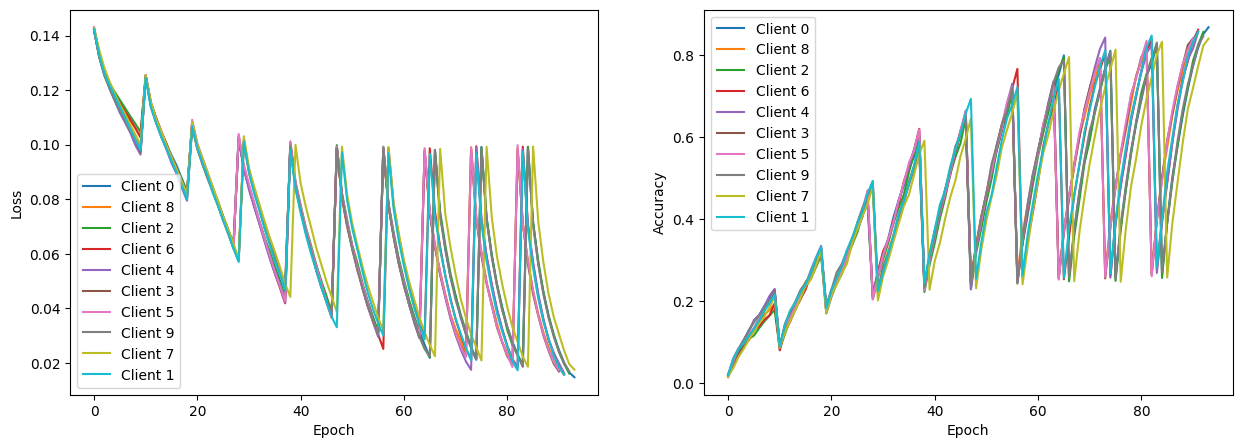

In [25]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

plot_metrics(strategy.client_metrics)

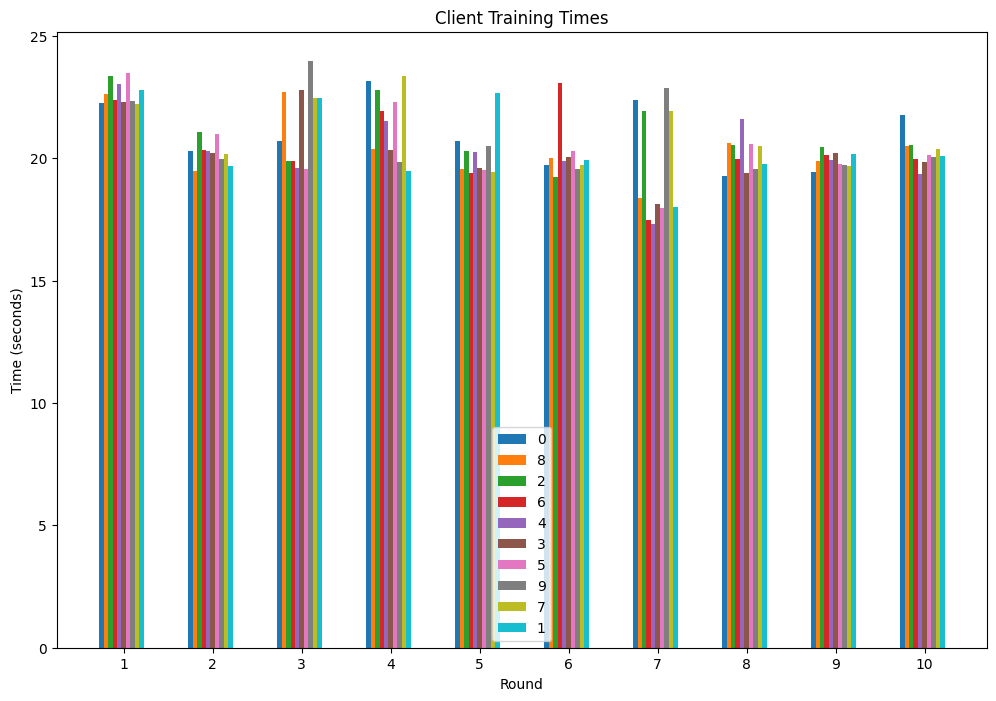

In [26]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [27]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 0 metrics: 94
Client 8 metrics: 91
Client 2 metrics: 93
Client 6 metrics: 92
Client 4 metrics: 92
Client 3 metrics: 91
Client 5 metrics: 91
Client 9 metrics: 93
Client 7 metrics: 94
Client 1 metrics: 92


In [28]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [29]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [30]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-16 10:31:19,162	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 27608913100.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 55217826203.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57164) [Client 1] get_parameters
(ClientAppActor pid=57164) [Client 8] fit, config: {}
(ClientAppActor pid=57164) Epoch 0: train loss 0.142724, accuracy 0.019111
(ClientAppActor pid=57164) Epoch 1: train loss 0.131414, accuracy 0.055778
(ClientAppActor pid=56220) [Client 7] fit, config: {}
(ClientAppActor pid=57164) Epoch 2: train loss 0.124125, accuracy 0.084667
(ClientAppActor pid=46216) [Client 5] fit, config: {}
(ClientAppActor pid=56220) Epoch 0: train loss 0.143013, accuracy 0.015778
(ClientAppActor pid=54592) [Client 0] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=44220) Epoch 0: train loss 0.142357, accuracy 0.018000 [repeated 11x across cluster]
(ClientAppActor pid=35796) [Client 1] fit, config: {}
(ClientAppActor pid=35796) Epoch 1: train loss 0.130320, accuracy 0.059111 [repeated 17x across cluster]
(ClientAppActor pid=57164) [Client 3] fit, config: {}
(ClientAppActor pid=4484) Epoch 6: train loss 0.108806, accuracy 0.162000 [repeated 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56220) [Client 3] evaluate, config: {}
(ClientAppActor pid=56220) Epoch 9: train loss 0.099089, accuracy 0.216889 [repeated 2x across cluster]
(ClientAppActor pid=56220) Client 3 loss 0.13847463130950927
(ClientAppActor pid=56220) Client 3 accuracy 0.078
(ClientAppActor pid=44220) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54592) Client 8 loss 0.1395121612548828 [repeated 3x across cluster]
(ClientAppActor pid=54592) Client 8 accuracy 0.062 [repeated 3x across cluster]
(ClientAppActor pid=56220) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=46216) Client 0 loss 0.13827968502044677 [repeated 4x across cluster]
(ClientAppActor pid=46216) Client 0 accuracy 0.088 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57164) [Client 2] fit, config: {}
(ClientAppActor pid=57164) Epoch 0: train loss 0.122623, accuracy 0.105556
(ClientAppActor pid=57164) [Client 4] evaluate, config: {}
(ClientAppActor pid=57164) Client 4 loss 0.13979544734954835 [repeated 2x across cluster]
(ClientAppActor pid=57164) Client 4 accuracy 0.094 [repeated 2x across cluster]
(ClientAppActor pid=46216) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26804) Epoch 0: train loss 0.123309, accuracy 0.090667 [repeated 5x across cluster]
(ClientAppActor pid=44220) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=54592) Epoch 2: train loss 0.108652, accuracy 0.161111 [repeated 21x across cluster]
(ClientAppActor pid=4484) Epoch 7: train loss 0.087094, accuracy 0.283333 [repeated 21x across cluster]
(ClientAppActor pid=57164) [Client 5] fit, config: {}
(ClientAppActor pid=4484) Epoch 9: train loss 0.078428, accuracy 0.342667 [repeated 16x across cluster]
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=4484) Epoch 9: train loss 0.078231, accuracy 0.340444 [repeated 5x across cluster]
(ClientAppActor pid=4484) [Client 4] evaluate, config: {}
(ClientAppActor pid=4484) Client 4 loss 0.11693690967559814
(ClientAppActor pid=4484) Client 4 accuracy 0.184
(ClientAppActor pid=35796) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=44220) Client 1 loss 0.10809784269332885 [repeated 3x across cluster]
(ClientAppActor pid=44220) Client 1 accuracy 0.214 [repeated 3x across cluster]
(ClientAppActor pid=57164) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 5 loss 0.11192136907577514 [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 5 accuracy 0.168 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44220) [Client 8] fit, config: {}
(ClientAppActor pid=44220) [Client 7] evaluate, config: {}
(ClientAppActor pid=44220) Client 7 loss 0.10951824474334716 [repeated 2x across cluster]
(ClientAppActor pid=44220) Client 7 accuracy 0.198 [repeated 2x across cluster]
(ClientAppActor pid=44220) Epoch 0: train loss 0.106579, accuracy 0.185778
(ClientAppActor pid=46216) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=57164) Epoch 0: train loss 0.107283, accuracy 0.180000 [repeated 8x across cluster]
(ClientAppActor pid=56220) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=57164) Epoch 3: train loss 0.088246, accuracy 0.284667 [repeated 22x across cluster]
(ClientAppActor pid=4484) Epoch 7: train loss 0.069440, accuracy 0.410000 [repeated 18x across cluster]
(ClientAppActor pid=44220) [Client 9] fit, config: {}
(ClientAppActor pid=4484) Epoch 9: train loss 0.060098, accuracy 0.469111 [repeated 16x across cluster]
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=4484) Epoch 9: train loss 0.057510, accuracy 0.492444 [repeated 5x across cluster]
(ClientAppActor pid=4484) [Client 8] evaluate, config: {}
(ClientAppActor pid=4484) Client 8 loss 0.11247688913345337
(ClientAppActor pid=4484) Client 8 accuracy 0.212
(ClientAppActor pid=46216) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26804) Client 4 loss 0.11995926094055176 [repeated 3x across cluster]
(ClientAppActor pid=26804) Client 4 accuracy 0.212 [repeated 3x across cluster]
(ClientAppActor pid=35796) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54592) Client 6 loss 0.11619060230255127 [repeated 4x across cluster]
(ClientAppActor pid=54592) Client 6 accuracy 0.198 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44220) [Client 5] fit, config: {}
(ClientAppActor pid=44220) Epoch 0: train loss 0.102059, accuracy 0.212444
(ClientAppActor pid=44220) [Client 3] evaluate, config: {}
(ClientAppActor pid=44220) Client 3 loss 0.10947424840927124 [repeated 2x across cluster]
(ClientAppActor pid=44220) Client 3 accuracy 0.22 [repeated 2x across cluster]
(ClientAppActor pid=54592) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=26804) Epoch 0: train loss 0.101814, accuracy 0.220222 [repeated 8x across cluster]
(ClientAppActor pid=46216) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=44220) Epoch 5: train loss 0.065045, accuracy 0.442222 [repeated 20x across cluster]
(ClientAppActor pid=35796) Epoch 7: train loss 0.054572, accuracy 0.522444 [repeated 20x across cluster]
(ClientAppActor pid=56220) Epoch 7: train loss 0.052919, accuracy 0.529111 [repeated 18x across cluster]
(ClientAppActor pid=44220) [Client 7] fit, config: {}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35796) Epoch 9: train loss 0.043606, accuracy 0.608444 [repeated 5x across cluster]
(ClientAppActor pid=35796) [Client 1] evaluate, config: {}
(ClientAppActor pid=35796) Client 1 loss 0.11106130027770997
(ClientAppActor pid=35796) Client 1 accuracy 0.28
(ClientAppActor pid=57164) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=46216) Client 6 loss 0.12338358926773071 [repeated 3x across cluster]
(ClientAppActor pid=46216) Client 6 accuracy 0.206 [repeated 3x across cluster]
(ClientAppActor pid=54592) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26804) Client 9 loss 0.11955542182922363 [repeated 4x across cluster]
(ClientAppActor pid=26804) Client 9 accuracy 0.252 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=4484) [Client 2] fit, config: {}
(ClientAppActor pid=4484) [Client 4] evaluate, config: {}
(ClientAppActor pid=4484) Client 4 loss 0.12451595401763917 [repeated 2x across cluster]
(ClientAppActor pid=4484) Client 4 accuracy 0.204 [repeated 2x across cluster]
(ClientAppActor pid=4484) Epoch 0: train loss 0.099472, accuracy 0.235556
(ClientAppActor pid=56220) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56220) Epoch 0: train loss 0.099428, accuracy 0.242000 [repeated 8x across cluster]
(ClientAppActor pid=35796) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=46216) Epoch 2: train loss 0.075403, accuracy 0.362889 [repeated 23x across cluster]
(ClientAppActor pid=57164) Epoch 5: train loss 0.056176, accuracy 0.512667 [repeated 18x across cluster]
(ClientAppActor pid=57164) Epoch 7: train loss 0.046003, accuracy 0.588667 [repeated 16x across cluster]
(ClientAppActor pid=4484) [Client 8] fit, config: {}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44220) Epoch 9: train loss 0.033599, accuracy 0.698000 [repeated 5x across cluster]
(ClientAppActor pid=44220) [Client 0] evaluate, config: {}
(ClientAppActor pid=44220) Client 0 loss 0.12857841730117797
(ClientAppActor pid=44220) Client 0 accuracy 0.222
(ClientAppActor pid=57164) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=46216) Client 3 loss 0.12715295028686524 [repeated 3x across cluster]
(ClientAppActor pid=46216) Client 3 accuracy 0.214 [repeated 3x across cluster]
(ClientAppActor pid=26804) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 2 loss 0.1321474051475525 [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 2 accuracy 0.25 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44220) [Client 0] fit, config: {}
(ClientAppActor pid=44220) [Client 8] evaluate, config: {}
(ClientAppActor pid=44220) Client 8 loss 0.1292357292175293 [repeated 2x across cluster]
(ClientAppActor pid=44220) Client 8 accuracy 0.224 [repeated 2x across cluster]
(ClientAppActor pid=44220) Epoch 0: train loss 0.097139, accuracy 0.261556
(ClientAppActor pid=4484) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=4484) Epoch 0: train loss 0.097141, accuracy 0.264222 [repeated 8x across cluster]
(ClientAppActor pid=56220) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=4484) Epoch 3: train loss 0.061657, accuracy 0.468222 [repeated 22x across cluster]
(ClientAppActor pid=26804) Epoch 7: train loss 0.036040, accuracy 0.681111 [repeated 18x across cluster]
(ClientAppActor pid=44220) [Client 2] fit, config: {}
(ClientAppActor pid=26804) Epoch 9: train loss 0.026469, accuracy 0.756444 [repeated 17x across cluster]
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26804) Epoch 9: train loss 0.028815, accuracy 0.743111 [repeated 5x across cluster]
(ClientAppActor pid=26804) [Client 5] evaluate, config: {}
(ClientAppActor pid=26804) Client 5 loss 0.13836585140228272
(ClientAppActor pid=26804) Client 5 accuracy 0.238
(ClientAppActor pid=54592) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56220) Client 7 loss 0.13227230978012086 [repeated 3x across cluster]
(ClientAppActor pid=56220) Client 7 accuracy 0.266 [repeated 3x across cluster]
(ClientAppActor pid=44220) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=57164) Client 3 loss 0.1398166561126709 [repeated 4x across cluster]
(ClientAppActor pid=57164) Client 3 accuracy 0.214 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26804) [Client 6] fit, config: {}
(ClientAppActor pid=26804) Epoch 0: train loss 0.098096, accuracy 0.249556
(ClientAppActor pid=26804) [Client 9] evaluate, config: {}
(ClientAppActor pid=26804) Client 9 loss 0.14140206098556518 [repeated 2x across cluster]
(ClientAppActor pid=26804) Client 9 accuracy 0.236 [repeated 2x across cluster]
(ClientAppActor pid=57164) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56220) Epoch 0: train loss 0.095482, accuracy 0.267556 [repeated 5x across cluster]
(ClientAppActor pid=35796) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=56220) Epoch 3: train loss 0.055202, accuracy 0.518000 [repeated 20x across cluster]
(ClientAppActor pid=35796) Epoch 3: train loss 0.057367, accuracy 0.491556 [repeated 17x across cluster]
(ClientAppActor pid=35796) Epoch 5: train loss 0.042396, accuracy 0.619333 [repeated 16x across cluster]
(ClientAppActor pid=26804) [Client 9] fit, config: {}
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46216) [Client 9] evaluate, config: {}
(ClientAppActor pid=46216) Client 9 loss 0.152142822265625
(ClientAppActor pid=46216) Client 9 accuracy 0.224
(ClientAppActor pid=46216) Epoch 9: train loss 0.022125, accuracy 0.799778 [repeated 2x across cluster]
(ClientAppActor pid=4484) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54592) Client 4 loss 0.15568618059158326 [repeated 3x across cluster]
(ClientAppActor pid=54592) Client 4 accuracy 0.23 [repeated 3x across cluster]
(ClientAppActor pid=56220) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26804) Client 7 loss 0.14359676027297974 [repeated 4x across cluster]
(ClientAppActor pid=26804) Client 7 accuracy 0.26 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=57164) [Client 1] fit, config: {}
(ClientAppActor pid=57164) [Client 0] evaluate, config: {}
(ClientAppActor pid=57164) Client 0 loss 0.14680210733413696 [repeated 2x across cluster]
(ClientAppActor pid=57164) Client 0 accuracy 0.228 [repeated 2x across cluster]
(ClientAppActor pid=57164) Epoch 0: train loss 0.096068, accuracy 0.276889
(ClientAppActor pid=35796) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=35796) Epoch 0: train loss 0.099495, accuracy 0.255556 [repeated 8x across cluster]
(ClientAppActor pid=44220) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=35796) Epoch 3: train loss 0.052804, accuracy 0.527333 [repeated 22x across cluster]
(ClientAppActor pid=46216) Epoch 6: train loss 0.032594, accuracy 0.698222 [repeated 18x across cluster]
(ClientAppActor pid=57164) [Client 5] fit, config: {}
(ClientAppActor pid=46216) Epoch 8: train loss 0.023536, accuracy 0.786222 [repeated 16x across cluster]
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26804) Epoch 9: train loss 0.019332, accuracy 0.826222 [repeated 5x across cluster]
(ClientAppActor pid=26804) [Client 7] evaluate, config: {}
(ClientAppActor pid=26804) Client 7 loss 0.15343894529342653
(ClientAppActor pid=26804) Client 7 accuracy 0.266
(ClientAppActor pid=4484) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=57164) Client 9 loss 0.16034764289855957 [repeated 3x across cluster]
(ClientAppActor pid=57164) Client 9 accuracy 0.216 [repeated 3x across cluster]
(ClientAppActor pid=56220) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=46216) Client 0 loss 0.15754054737091064 [repeated 4x across cluster]
(ClientAppActor pid=46216) Client 0 accuracy 0.214 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26804) [Client 0] fit, config: {}
(ClientAppActor pid=26804) [Client 5] evaluate, config: {}
(ClientAppActor pid=26804) Client 5 loss 0.1603627142906189 [repeated 2x across cluster]
(ClientAppActor pid=26804) Client 5 accuracy 0.23 [repeated 2x across cluster]
(ClientAppActor pid=26804) Epoch 0: train loss 0.097083, accuracy 0.270444
(ClientAppActor pid=46216) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=46216) Epoch 0: train loss 0.100019, accuracy 0.258667 [repeated 8x across cluster]
(ClientAppActor pid=57164) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=46216) Epoch 3: train loss 0.050099, accuracy 0.551778 [repeated 21x across cluster]
(ClientAppActor pid=35796) Epoch 6: train loss 0.027041, accuracy 0.756667 [repeated 19x across cluster]
(ClientAppActor pid=54592) Epoch 7: train loss 0.022243, accuracy 0.792444 [repeated 18x across cluster]
(ClientAppActor pid=26804) [Client 8] fit, config: {}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56220) Epoch 9: train loss 0.016548, accuracy 0.849778 [repeated 5x across cluster]
(ClientAppActor pid=56220) [Client 3] evaluate, config: {}
(ClientAppActor pid=56220) Client 3 loss 0.1708322591781616
(ClientAppActor pid=56220) Client 3 accuracy 0.218
(ClientAppActor pid=54592) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=44220) Client 0 loss 0.16548852252960206 [repeated 3x across cluster]
(ClientAppActor pid=44220) Client 0 accuracy 0.194 [repeated 3x across cluster]
(ClientAppActor pid=44220) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 9 loss 0.16881266593933106 [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 9 accuracy 0.22 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35796) [Client 6] fit, config: {}
(ClientAppActor pid=35796) Epoch 0: train loss 0.098927, accuracy 0.277333
(ClientAppActor pid=35796) [Client 7] evaluate, config: {}
(ClientAppActor pid=35796) Client 7 loss 0.1631074643135071 [repeated 2x across cluster]
(ClientAppActor pid=35796) Client 7 accuracy 0.258 [repeated 2x across cluster]
(ClientAppActor pid=54592) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54592) Epoch 0: train loss 0.100498, accuracy 0.263111 [repeated 8x across cluster]
(ClientAppActor pid=26804) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=54592) Epoch 3: train loss 0.047820, accuracy 0.571778 [repeated 22x across cluster]
(ClientAppActor pid=44220) Epoch 7: train loss 0.019899, accuracy 0.813778 [repeated 18x across cluster]
(ClientAppActor pid=35796) [Client 9] fit, config: {}
(ClientAppActor pid=44220) Epoch 9: train loss 0.013392, accuracy 0.880444 [repeated 16x across cluster]
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44220) Epoch 9: train loss 0.014854, accuracy 0.860222 [repeated 5x across cluster]
(ClientAppActor pid=44220) [Client 5] evaluate, config: {}
(ClientAppActor pid=44220) Client 5 loss 0.17645353031158448
(ClientAppActor pid=44220) Client 5 accuracy 0.232
(ClientAppActor pid=57164) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56220) Client 8 loss 0.17722737503051758 [repeated 3x across cluster]
(ClientAppActor pid=56220) Client 8 accuracy 0.216 [repeated 3x across cluster]
(ClientAppActor pid=44220) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 2 loss 0.1843629879951477 [repeated 4x across cluster]
(ClientAppActor pid=4484) Client 2 accuracy 0.23 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 640.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.1389185598373413
INFO :      		round 2: 0.1112263939857483
INFO :      		round 3: 0.11202331748008727
INFO :      		round 4: 0.11837077593803406
INFO :      		round 5: 0.12852822470664976
INFO :      		round 6: 0.13955702867507935
INFO :      		round 7: 0.1501130262851715
INFO :      		round 8: 0.16027402114868167
INFO :      		round 9: 0.16899171600341797
INFO :      		round 10: 0.1770402988433838
INFO :      


History (loss, distributed):
	round 1: 0.1389185598373413
	round 2: 0.1112263939857483
	round 3: 0.11202331748008727
	round 4: 0.11837077593803406
	round 5: 0.12852822470664976
	round 6: 0.13955702867507935
	round 7: 0.1501130262851715
	round 8: 0.16027402114868167
	round 9: 0.16899171600341797
	round 10: 0.1770402988433838

(ClientAppActor pid=35796) Client 9 loss 0.17625357341766357
(ClientAppActor pid=35796) Client 9 accuracy 0.218


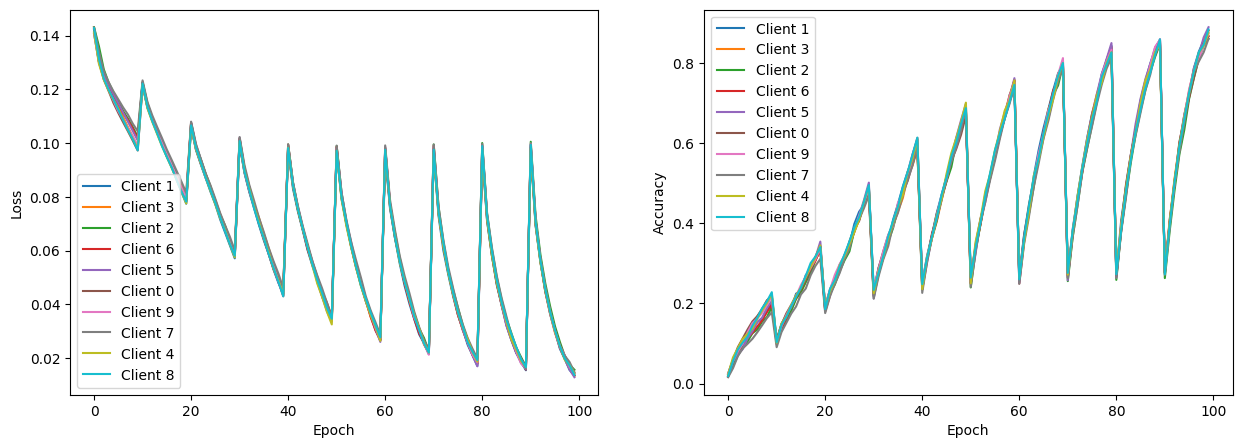

In [31]:
plot_metrics(strategy_fed_avg.client_metrics)

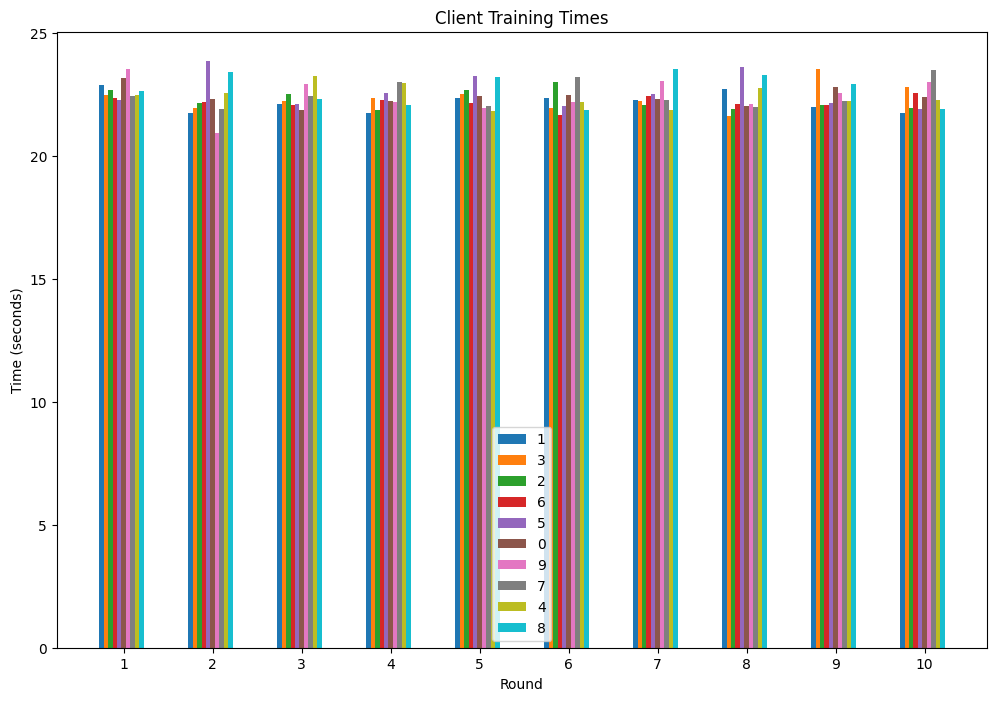

In [32]:
plot_times(strategy_fed_avg.client_training_times)